In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Download required NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
# Download the missing punkt_tab resource
nltk.download("punkt_tab")

# Preprocessing function
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

# Load CSV
# Replace this with the actual path to your file on the Linux system
# Example: '/path/to/your/file/nlp-jobposting-dataset.csv'
df = pd.read_csv('/content/job_postings.csv')
df = df[['title', 'description']].dropna()

# Preprocess description
df['processed_description'] = df['description'].apply(preprocess_text)

# Save for next step
df.to_csv("processed_job_descriptions.csv", index=False)

print("Job descriptions processed and saved.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Job descriptions processed and saved.


In [ ]:
import zipfile
import os

# Extract resumes.zip
with zipfile.ZipFile("/content/resumes.zip", 'r') as zip_ref:
    zip_ref.extractall("resumes")  # Extract to 'resumes' folder


In [ ]:
!pip install pymupdf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 101.2 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download("punkt")         # Main tokenizer
nltk.download("punkt_tab")     # Fixes the current error (manually trigger if needed)
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import fitz  # PyMuPDF
import pandas as pd
import nltk
import glob
import os

# Download NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

# Recursively find all PDFs inside 'resumes' folder
pdf_paths = glob.glob("resumes/**/*.pdf", recursive=True)
print(f"Found {len(pdf_paths)} PDF files.")

# Extract and preprocess text from each PDF
resumes_data = []

for file_path in pdf_paths:
    filename = os.path.basename(file_path)
    try:
        doc = fitz.open(file_path)
        text = ""
        for page in doc:
            text += page.get_text()
        processed = preprocess_text(text)
        resumes_data.append({
            "filename": filename,
            "processed_resume": processed
        })
    except Exception as e:
        print(f"Failed to process {filename}: {e}")

# Save to CSV
df_resumes = pd.DataFrame(resumes_data)
df_resumes.to_csv("processed_resumes.csv", index=False)

print(f"Processed {len(df_resumes)} PDF resumes.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Found 2484 PDF files.
Processed 2484 PDF resumes.


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load preprocessed CSVs
jobs_df = pd.read_csv("processed_job_descriptions.csv")
resumes_df = pd.read_csv("processed_resumes.csv")

# Drop any rows where processed text is missing
jobs_df.dropna(subset=['processed_description'], inplace=True)
resumes_df.dropna(subset=['processed_resume'], inplace=True)

# Reset index (not required, but clean)
jobs_df.reset_index(drop=True, inplace=True)
resumes_df.reset_index(drop=True, inplace=True)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit TF-IDF on job descriptions
job_tfidf = vectorizer.fit_transform(jobs_df['processed_description'])

# Transform resumes using the same vectorizer
resume_tfidf = vectorizer.transform(resumes_df['processed_resume'])

# Compute cosine similarity between each resume and all jobs
similarity_matrix = cosine_similarity(resume_tfidf, job_tfidf)
# Get top 3 matches for each resume
top_matches = []

for resume_idx, similarity_scores in enumerate(similarity_matrix):
    # Get top 3 job indices sorted by score (descending)
    top_job_indices = similarity_scores.argsort()[::-1][:3]
    resume_filename = resumes_df.iloc[resume_idx]['filename']

    for rank, job_idx in enumerate(top_job_indices, start=1):
        job_title = jobs_df.iloc[job_idx]['title']
        score = similarity_scores[job_idx]
        top_matches.append({
            'resume_filename': resume_filename,
            'rank': rank,
            'matched_job_title': job_title,
            'similarity_score': round(score, 4)
        })
# Convert to DataFrame and save
matches_df = pd.DataFrame(top_matches)
matches_df.to_csv("resume_job_matches.csv", index=False)
print("Step 3 complete! Saved matches to 'resume_job_matches.csv'")

Step 3 complete! Saved matches to 'resume_job_matches.csv'


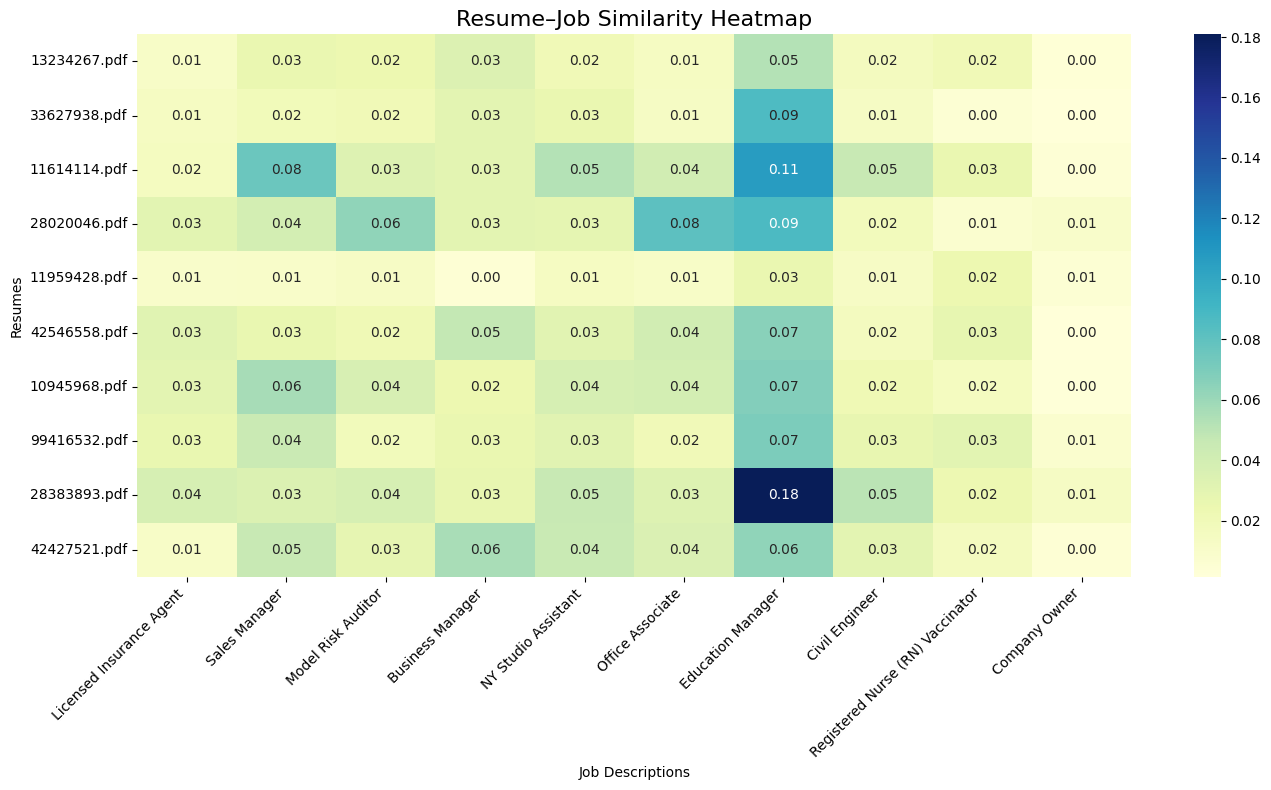

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 10 resumes and top 10 jobs for visualization
n = 10
sample_resume_indices = range(min(n, resume_tfidf.shape[0]))
sample_job_indices = range(min(n, job_tfidf.shape[0]))

# Slice the similarity matrix
heatmap_matrix = similarity_matrix[sample_resume_indices][:, sample_job_indices]

# Labels for axes
resume_labels = resumes_df.iloc[list(sample_resume_indices)]['filename'].tolist()
job_labels = jobs_df.iloc[list(sample_job_indices)]['title'].tolist()

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", xticklabels=job_labels, yticklabels=resume_labels, cmap="YlGnBu")
plt.title("Resume–Job Similarity Heatmap", fontsize=16)
plt.xlabel("Job Descriptions")
plt.ylabel("Resumes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()